# Setting up a basic ReAct Agent in LangGraph

In [14]:
import os

os.environ["OPENAI_API_KEY"] = 'sk-***'
os.environ["SERPAPI_API_KEY"] = 's***'  # https://serpapi.com for a free token!

In [3]:
from langchain_community.agent_toolkits.load_tools import load_tools
tools = load_tools(["serpapi"])


In [4]:
tools[0].run('Sinan Ozdemir')

'[\'Sinan Ozdemir is currently the founder and CTO of LoopGenius and an advisor to several AI companies. Sinan is a former lecturer of Data Science at Johns Hopkins University and the author of multiple textbooks on data science and machine learning. ...\', \'Sinan Ozdemir type: Author.\', \'Sinan Ozdemir entity_type: people.\', \'Sinan Ozdemir kgmid: /g/11hcjs9cr6.\', \'Specialized in areas including time management as well as mathematics and computer science logistics.\', \'Helping companies leverage AI technology to solve complex problems. Founder, author, and consultant specializing in AI, LLMs, and data science.\', \'Data Scientist + Author + Entrepreneur. Check out my new book on LLMs on Amazon (Top 10 in AI/NLP) - sinanuozdemir.\', \'NLP + Gen AI Expert / LLM whisperer. AI Author. Founder @Aikylie (acquired). Contributor on @Forbes. Fellow @YCombinator. San Francisco, CA.\', "A beginner\'s guide to essential math and coding skills for data fluency and machine learning by Sinan O

In [16]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from datetime import datetime

today = datetime.today().strftime("%B ") + str(datetime.today().day) + ("th" if 11<=datetime.today().day<=13 else {1:"st",2:"nd",3:"rd"}.get(datetime.today().day%10,"th")) + datetime.today().strftime(", %Y")
print(today)

llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools, state_modifier=f'Today is {today}')  # true as of today :)

September 24th, 2025


In [9]:
response = agent_executor.invoke({"messages": [("user", "Who is the current Ravens QB?")]})

In [10]:
response['messages'][-1].content

'The current quarterback for the Baltimore Ravens is Lamar Jackson.'

In [11]:
# if I didn't put the date in, it might use a past year like 2023 as the query instead of
#  {"query":"current Baltimore Ravens quarterback 2025"}
for event in agent_executor.stream({"messages": [("user", "Who is the current Ravens QB?")]}):
    print(event)


{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_yRoRwbN1ihVyXIhX6hO23Tsn', 'function': {'arguments': '{"__arg1":"current Baltimore Ravens quarterback September 2025"}', 'name': 'Search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 84, 'total_tokens': 106, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CJKKquhwU6ueIvMnRTsioOJADd4bI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--16d1fb93-1a41-4f58-be86-904fae20ec69-0', tool_calls=[{'name': 'Search', 'args': {'__arg1': 'current Baltimore Ravens quarterback September 2025'}, 'id': 'call_yRoRwbN1ihVyXIhX6hO23Tsn', 'type': 'tool_call'}

In [12]:
print(event['agent']['messages'][-1].content)

The current quarterback for the Baltimore Ravens is Lamar Jackson. He is a two-time NFL MVP and is expected to sign a new contract that will make him the highest-paid player in the league.


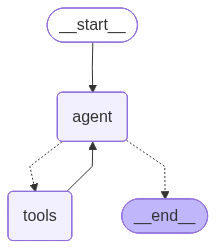

In [12]:
# Compile the graph
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [13]:
response = agent_executor.invoke({"messages": [("user", "Who is Sinan Ozdemir?")]})

print(response['messages'][-1].content)

Sinan Ozdemir is a prominent figure in the fields of data science and artificial intelligence. He is currently the founder and CTO of LoopGenius and serves as an advisor to various AI companies. Ozdemir has a background as a lecturer in Data Science at Johns Hopkins University and has authored multiple textbooks on topics related to data science and machine learning.

He specializes in leveraging AI technology to solve complex problems and has expertise in natural language processing (NLP) and large language models (LLMs). Additionally, he is known for his contributions to publications like Forbes and is recognized as a fellow at Y Combinator. Ozdemir is also the founder of Aikylie, which has been acquired, and he remains actively involved in teaching and writing within his areas of expertise.


# Turn our ReAct Agent into a Chat

In [13]:
from langgraph.graph import MessagesState, END, StateGraph, START
from langchain_core.messages import HumanMessage, AIMessage

In [16]:
class ConvoState(MessagesState):
    # MessagesState already has messages in it
    end: bool

def get_user_input(state):
    user_msg = input("\n🧑 You: ")
    if user_msg.strip().lower() == "exit":
        return {'end': True}
    return {"messages": HumanMessage(content=user_msg)}

def run_agent(state):
    print(f'num of messages: {len(state["messages"])}')
    response = agent_executor.invoke({"messages": state["messages"]})
    print(f"\n🤖 Agent: {response['messages'][-1].content}")
    print(f'num of messages: {len(response['messages'])}')
    return {"messages": response['messages'][len(state['messages']):]}

graph_builder = StateGraph(ConvoState)
graph_builder.add_node("get_user_input", get_user_input)
graph_builder.add_node("run_agent", run_agent)

graph_builder.set_entry_point("get_user_input")
graph_builder.add_conditional_edges(
    "get_user_input", 
    lambda state: 'end' if state.get('end') else 'go',
    {
        'end': END,
        'go': 'run_agent'
    }
)
graph_builder.add_edge("run_agent", "get_user_input")

graph = graph_builder.compile()

In [18]:

print("💬 Start chatting with the agent! Type 'exit' to stop.")
state = graph.invoke({"messages": []})

💬 Start chatting with the agent! Type 'exit' to stop.



🧑 You:  hi


num of messages: 1

🤖 Agent: Hello! How can I assist you today?
num of messages: 2



🧑 You:  weather in sf please


num of messages: 3

🤖 Agent: The current weather in San Francisco is partly cloudy with a temperature of 68°F. The humidity is at 67%, and there's no precipitation expected. There's a light wind blowing at 10 mph.
num of messages: 6



🧑 You:  thanks


num of messages: 7

🤖 Agent: You're welcome! If you have any more questions or need assistance with anything else, feel free to ask!
num of messages: 8



🧑 You:  exit


In [22]:
for message in state['messages']:
    print(type(message), message.content, 'Tool ID:' + message.tool_call_id if hasattr(message, 'tool_call_id') else '')
    if message.additional_kwargs.get('tool_calls'):
        tool_calls = message.additional_kwargs.get('tool_calls')
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["function"]["name"]}), Args({tool_call["function"]["arguments"]})')
    elif hasattr(message, 'tool_calls'):
        tool_calls = message.tool_calls
        for tool_call in tool_calls:
            print(f'Tool Call: ID({tool_call["id"]}), Name({tool_call["name"]}), Args({tool_call["args"]})')
    print('----')

<class 'langchain_core.messages.human.HumanMessage'> hi 
----
<class 'langchain_core.messages.ai.AIMessage'> Hello! How can I assist you today? 
----
<class 'langchain_core.messages.human.HumanMessage'> weather in sf please 
----
<class 'langchain_core.messages.ai.AIMessage'>  
Tool Call: ID(call_i56kZkkVF3KvKzi3479nqjzd), Name(Search), Args({"__arg1":"current weather in San Francisco"})
----
<class 'langchain_core.messages.tool.ToolMessage'> {'type': 'weather_result', 'temperature': '68', 'unit': 'Fahrenheit', 'precipitation': '0%', 'humidity': '67%', 'wind': '10 mph', 'location': 'San Francisco, CA', 'date': 'Friday 2:00 PM', 'weather': 'Partly cloudy'} Tool ID:call_i56kZkkVF3KvKzi3479nqjzd
----
<class 'langchain_core.messages.ai.AIMessage'> The current weather in San Francisco is partly cloudy with a temperature of 68°F. The humidity is at 67%, and there's no precipitation expected. There's a light wind blowing at 10 mph. 
----
<class 'langchain_core.messages.human.HumanMessage'> th

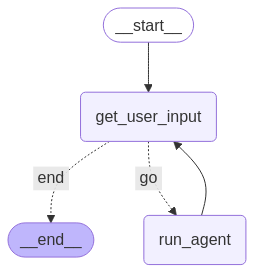

In [86]:
# Compile the graph
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))